In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [2]:
#importing dataset
df = pd.read_csv("C:/Users/HP/Documents/EXP/NFLX.csv")
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200
1008,2022-02-04,407.309998,412.769989,396.640015,410.170013,410.170013,7782400


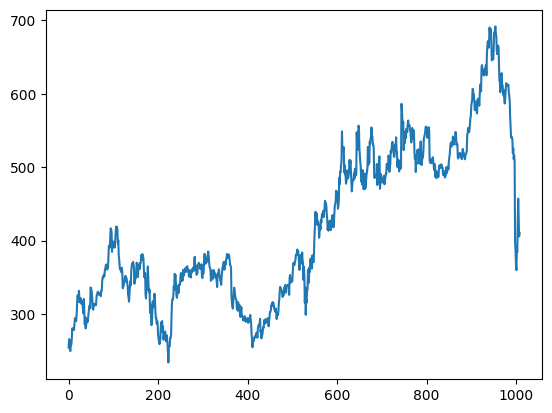

In [5]:
#close value inspection
df1 = df.reset_index()['Close']
df1.shape
plt.plot(df['Close'])


In [6]:
#scaling values between (0,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
#it has now transformed to an array
print(df1)

[[0.04451626]
 [0.06954849]
 [0.06701469]
 ...
 [0.4272515 ]
 [0.37509011]
 [0.38507243]]


Preprocessing

In [10]:
train_len = int(len(df1)*0.60)      #60 % dataset will be used as training set
test_len = int(len(df1)-train_len)  #test of datasset is used as testing dataset

train_data = df1[0:train_len:]
test_data = df1[train_len:len(df1):1]

In [11]:
train_len,test_len

(605, 404)

In [12]:
len(train_data),len(test_data)

(605, 404)

In [17]:
#Dataset Matrix
def create_dataset(dataset,time_step= 1):
    dataX,dataY =[],[]
    for i in range(len(dataset)-time_step - 1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX),np.array(dataY)


In [23]:
time_step=100
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test = create_dataset(test_data,time_step)

In [24]:
print(x_train.shape),print(y_train.shape)

(504, 100)
(504,)


(None, None)

In [25]:
print((x_test.shape),print(y_test.shape))

(303,)
(303, 100) None


Creating a stacked LSTM

In [28]:
#Stacked LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [31]:
model =Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
8/8 [==============================] - 22s 862ms/step - loss: 0.0279 - val_loss: 0.0080
Epoch 2/50
8/8 [==============================] - 4s 502ms/step - loss: 0.0060 - val_loss: 0.0959
Epoch 3/50
8/8 [==============================] - 5s 621ms/step - loss: 0.0050 - val_loss: 0.0167
Epoch 4/50
8/8 [==============================] - 3s 413ms/step - loss: 0.0040 - val_loss: 0.0401
Epoch 5/50
8/8 [==============================] - 3s 355ms/step - loss: 0.0033 - val_loss: 0.0138
Epoch 6/50
8/8 [==============================] - 3s 348ms/step - loss: 0.0029 - val_loss: 0.0142
Epoch 7/50
8/8 [==============================] - 3s 321ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 8/50
8/8 [==============================] - 3s 326ms/step - loss: 0.0024 - val_loss: 0.0064
Epoch 9/50
8/8 [==============================] - 3s 346ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 10/50
8/8 [==============================] - 3s 384ms/step - loss: 0.0022 - val_loss: 0.0054
Epoch 11/50
8/8 [=

In [34]:
#predicting and checcking performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

10/10 [==============================] - 1s 69ms/step


In [35]:
#transform back to original form
#because the data we have scaled down needs to be get in original
train_predict =scaler.inverse_transform(train_predict)
test_predict= scaler.inverse_transform(test_predict)

In [36]:
import math
from sklearn.metrics import mean_squared_error

In [37]:
#calculate RMSE performance metrics for train data
math.sqrt(mean_squared_error(y_train,train_predict))

347.05798811177317

In [38]:
#test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

571.6965387842848

PLotting the prediction

In [41]:
#shift train prediction for plotting
look_back=100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, : ] = train_predict


In [43]:
#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1 : len(df1)-1, :]= test_predict


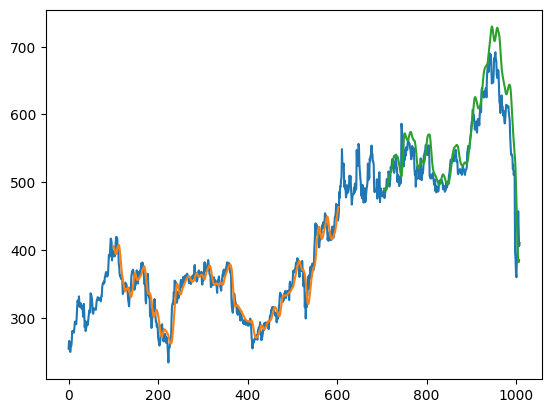

In [44]:
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [45]:
len(test_data)

404

In [46]:
#to preddict the price after 100 days
404-100

304

In [47]:
x_input = test_data[304:].reshape(1,-1)
x_input.shape

(1, 100)

In [48]:
temp_input=list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.7623031220089325,
 0.770232186519946,
 0.7764574241046989,
 0.7460518342503559,
 0.741049807175792,
 0.779297134920363,
 0.7849981594001756,
 0.7830978186350088,
 0.7836438967059076,
 0.7644437065449226,
 0.797667144433283,
 0.8223062503372986,
 0.8284441613012656,
 0.8070377960750383,
 0.8757563085718285,
 0.8851269602135838,
 0.8692906961575151,
 0.8710599825542908,
 0.8587841584420446,
 0.8541971550699885,
 0.8647255577514177,
 0.8735501313222742,
 0.8615145487965392,
 0.8826586764115594,
 0.884908581408719,
 0.854634045922767,
 0.9158383843680022,
 0.9412202154248719,
 0.9562481616145222,
 0.9493895237067091,
 0.9371572940990189,
 0.9614687007370002,
 0.9969856403113886,
 0.9770209932746399,
 0.9694850896844873,
 0.9925732858122798,
 0.9491274149699269,
 0.8995870966094257,
 0.9121032955512327,
 0.9220200252638868,
 0.9021864325955293,
 0.9254931407712357,
 0.9801664073316425,
 0.9730019329394415,
 0.9906293483582447,
 1.0,
 0.9788777395352508,
 0.9718441840840797,
 0.9290317157

In [54]:
lst_output =[]
n_steps =100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

0 day input [0.9614687  0.99698564 0.97702099 0.96948509 0.99257329 0.94912741
 0.8995871  0.9121033  0.92202003 0.90218643 0.92549314 0.98016641
 0.97300193 0.99062935 1.         0.97887774 0.97184418 0.92903172
 0.91780432 0.92704392 0.94309869 0.93916696 0.89124314 0.83853568
 0.83569596 0.804373   0.82743933 0.85559515 0.86105593 0.82374784
 0.82518942 0.80968086 0.79532991 0.81072929 0.78019265 0.77073453
 0.78604659 0.81046718 0.83082499 0.83049742 0.82837857 0.82311443
 0.82274301 0.8261288  0.80505013 0.79397565 0.78038929 0.72877398
 0.69769113 0.67097703 0.66833397 0.67049655 0.66258921 0.623228
 0.63740416 0.60487972 0.61593233 0.59930975 0.35739716 0.33478952
 0.28950877 0.27483019 0.33380662 0.32869527 0.42214021 0.48764772
 0.4272515  0.37509011 0.38507243 0.35533169 0.36661708 0.37484366
 0.38051707 0.38441572 0.38722628 0.38943017 0.39131194 0.39300996
 0.39457253 0.39600101 0.3972784  0.39838606 0.39931077 0.4000468
 0.40059572 0.4009648  0.40116516 0.4012104  0.401115

In [55]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)


In [56]:
len(df1)

1009

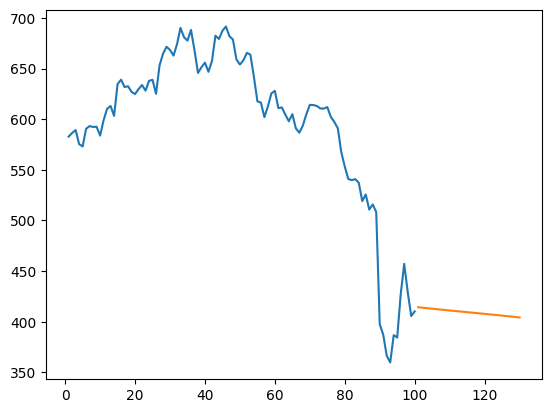

In [59]:
plt.plot(day_new,scaler.inverse_transform(df1[909:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))


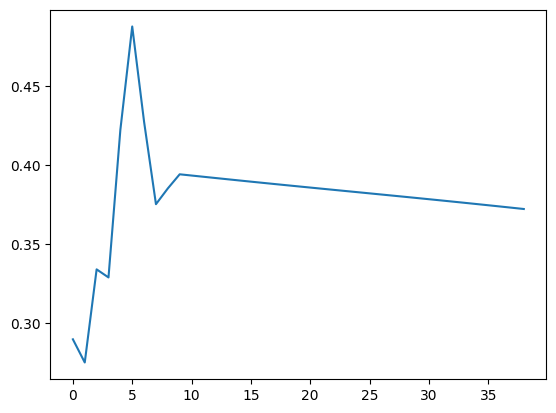

In [61]:
df3= df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])